<a href="https://colab.research.google.com/github/nahlatafi/draft_skinnea/blob/main/%232_Trial_Skripsi_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Identifikasi Jenis Penyakit Kulit Melalui Pengolahan Citra Digital Menggunakan Metode CNN**

1. Impor Library dan modul

In [ ]:
from google.colab import drive
import os

import tensorflow as tf
import tensorflow_hub as hub

from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

2. Menentukan Parameter dan Modul

In [ ]:
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/new-dataset"

Mounted at /content/drive
test  train  val


In [ ]:
# Fungsi untuk menghitung jumlah gambar dalam folder untuk label tertentu
def count_images_in_folder(folder_path, labels):
    label_counts = {label: 0 for label in labels}

    # Menghitung jumlah file gambar untuk setiap label
    for label in labels:
        label_path = os.path.join(folder_path, label)
        files = os.listdir(label_path)
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                label_counts[label] += 1

    return label_counts

# Fungsi untuk menghitung total jumlah gambar dalam sebuah direktori
def count_total_images_in_folder(folder_path, labels):
    total_count = 0
    for label in labels:
        label_path = os.path.join(folder_path, label)
        files = os.listdir(label_path)
        total_count += len([file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))])
    return total_count

if __name__ == '__main__':
    # Path ke folder-folder
    # train_dir = '/content/drive/MyDrive/dataset-nahla/train'
    # val_dir = '/content/drive/MyDrive/dataset-nahla/val'
    # test_dir = '/content/drive/MyDrive/dataset-nahla/test'

    # Path ke folder-folder
    train_dir = '/content/drive/MyDrive/new-dataset/train'
    val_dir = '/content/drive/MyDrive/new-dataset/val'
    test_dir = '/content/drive/MyDrive/new-dataset/test'


    # Label-label
    labels = ['Atopic-Dermatitis', 'Psoriasis', 'Scabies-Lyme']
    print('Jumlah kelas:', len(labels))
    for i, label in enumerate(labels):
        print(f"{i}: {label}")

    # Menghitung jumlah file gambar untuk setiap label di direktori pelatihan
    train_label_counts = count_images_in_folder(train_dir, labels)
    total_train_images = sum(train_label_counts.values())

    print("\nJumlah Data Training:", total_train_images)
    for label, count in train_label_counts.items():
        print(f"{label}: {count}")

    # Menghitung jumlah file gambar untuk setiap label di direktori validasi
    val_label_counts = count_images_in_folder(val_dir, labels)
    total_val_images = sum(val_label_counts.values())

    print("\nJumlah Data Validation:", total_val_images)
    for label, count in val_label_counts.items():
        print(f"{label}: {count}")

    # Menghitung jumlah file gambar untuk setiap label di direktori pengujian
    test_label_counts = count_images_in_folder(test_dir, labels)
    total_test_images = sum(test_label_counts.values())

    print("\nJumlah Data Testing:", total_test_images)
    for label, count in test_label_counts.items():
        print(f"{label}: {count}")

Jumlah kelas: 3
0: Atopic-Dermatitis
1: Psoriasis
2: Scabies-Lyme

Jumlah Data Training: 90
Atopic-Dermatitis: 30
Psoriasis: 30
Scabies-Lyme: 30

Jumlah Data Validation: 90
Atopic-Dermatitis: 30
Psoriasis: 30
Scabies-Lyme: 30

Jumlah Data Testing: 90
Atopic-Dermatitis: 30
Psoriasis: 30
Scabies-Lyme: 30


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

IMAGE_SIZE

(224, 224)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 54 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )

do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2915395 (11.12 MB)
Trainable params: 657411 (2.51 MB)
Non-trainable params: 2257984 (8.

In [ ]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
3/3 [==============================] - 14s 6s/step - loss: 0.5095 - accuracy: 0.7632 - val_loss: 1.9764 - val_accuracy: 0.4688
Epoch 2/15
3/3 [==============================] - 6s 2s/step - loss: 0.4708 - accuracy: 0.7917 - val_loss: 1.7009 - val_accuracy: 0.4688
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 0.2515 - accuracy: 0.9211 - val_loss: 1.1529 - val_accuracy: 0.5938
Epoch 4/15
3/3 [==============================] - 4s 2s/step - loss: 0.1169 - accuracy: 0.9474 - val_loss: 1.2036 - val_accuracy: 0.6875
Epoch 5/15
3/3 [==============================] - 5s 2s/step - loss: 0.2014 - accuracy: 0.8947 - val_loss: 1.6635 - val_accuracy: 0.5625
Epoch 6/15
3/3 [==============================] - 5s 2s/step - loss: 0.1386 - accuracy: 0.8947 - val_loss: 1.4771 - val_accuracy: 0.6250
Epoch 7/15
3/3 [==============================] - 4s 2s/step - loss: 0.1196 - accuracy: 0.9474 - val_loss: 1.7243 - val_accuracy: 0.5000
Epoch 8/15
3/3 [========================

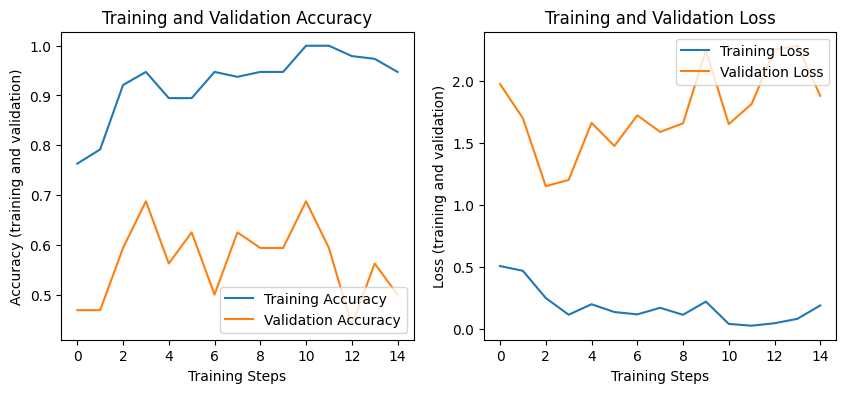

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 1s 568ms/step
class: Atopic-Dermatitis, confidence: 0.872977


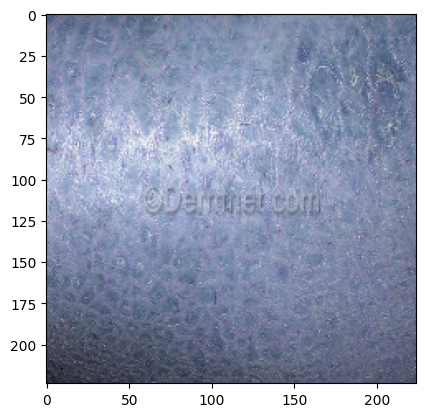

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 61ms/step
class: Scabies-Lyme, confidence: 0.953373


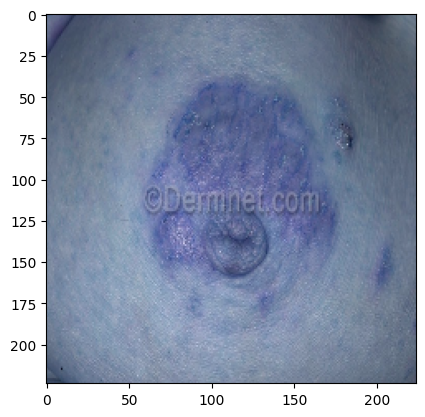

1/1 [==============================] - 0s 49ms/step
class: Scabies-Lyme, confidence: 0.586801


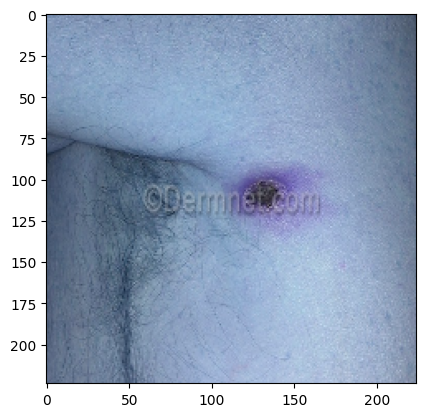

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 48ms/step
class: Atopic-Dermatitis, confidence: 0.611734


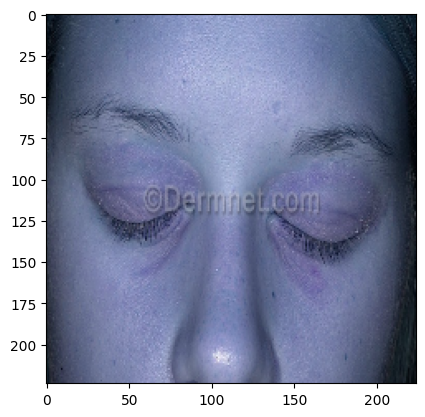

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 48ms/step
class: Psoriasis, confidence: 0.500470


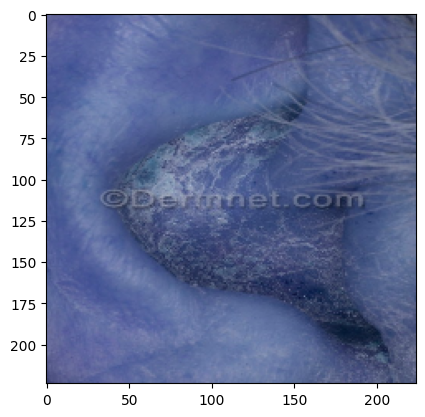

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 51ms/step
class: Psoriasis, confidence: 0.764287


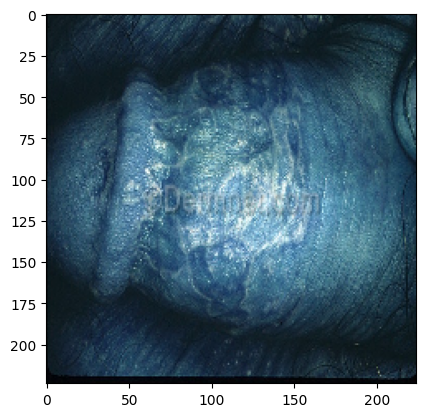

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 55ms/step
class: Atopic-Dermatitis, confidence: 0.993851


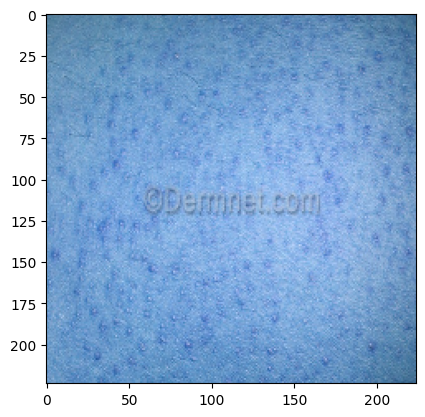

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 69ms/step
class: Scabies-Lyme, confidence: 0.970281


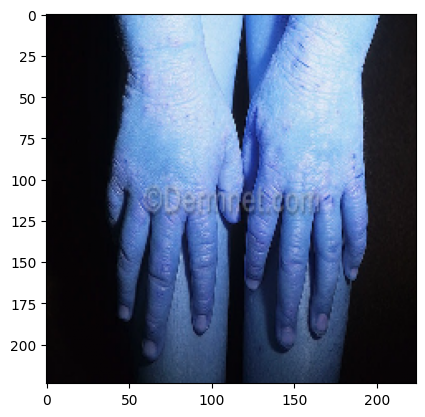

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 79ms/step
class: Scabies-Lyme, confidence: 0.924353


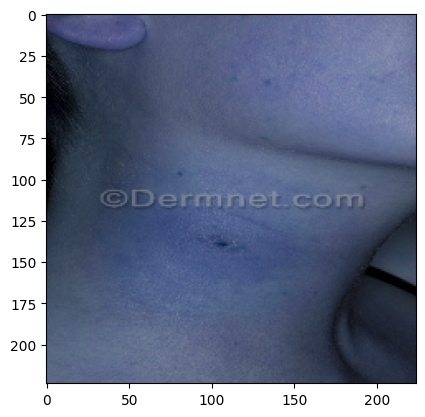

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 55ms/step
class: Atopic-Dermatitis, confidence: 0.942643


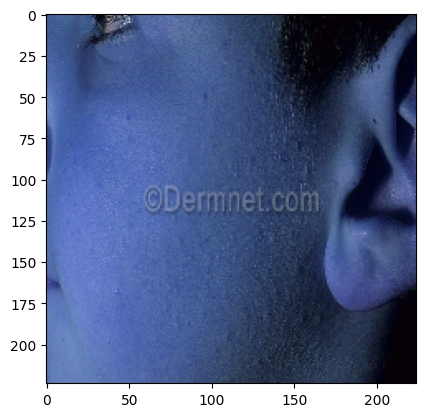

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 66ms/step
class: Scabies-Lyme, confidence: 0.836798


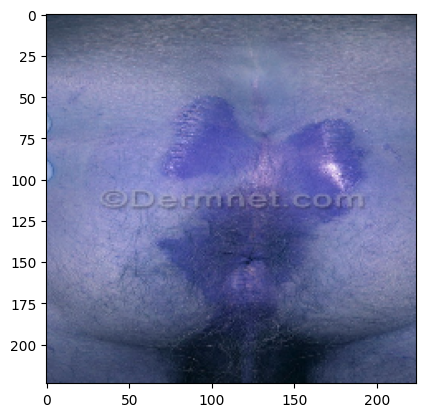

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 91ms/step
class: Atopic-Dermatitis, confidence: 0.999990


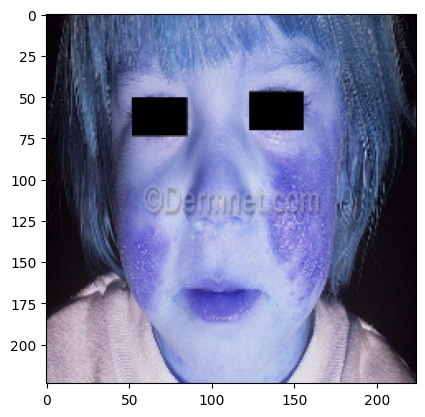

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 69ms/step
class: Scabies-Lyme, confidence: 0.979093


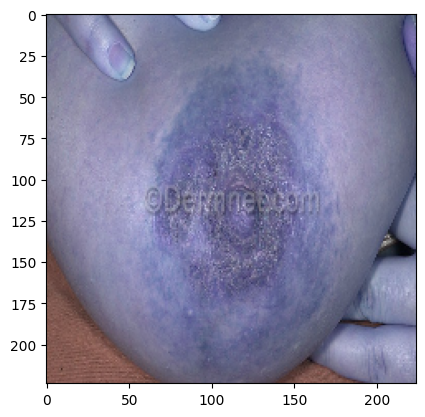

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 113ms/step
class: Scabies-Lyme, confidence: 0.998928


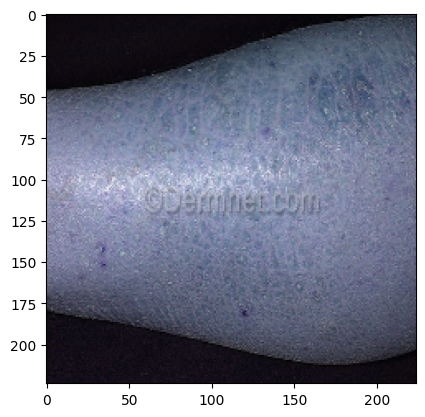

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 86ms/step
class: Scabies-Lyme, confidence: 0.497755


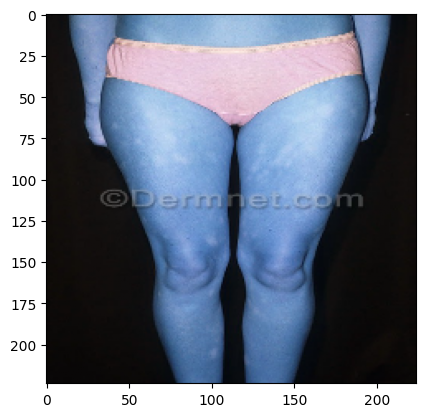

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 92ms/step
class: Scabies-Lyme, confidence: 0.998565


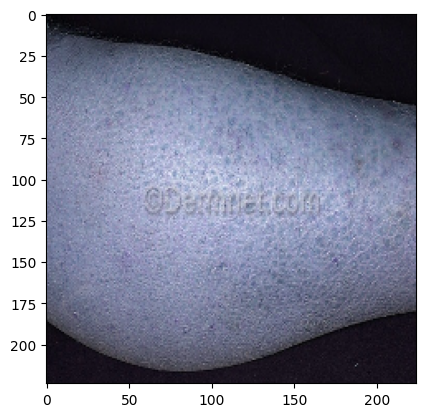

<Figure size 640x480 with 0 Axes>

In [ ]:
import random
import cv2

def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img / 255

    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)

    return {labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

3/3 [==============================] - 3s 572ms/step
Classification Report
                   precision    recall  f1-score   support

Atopic-Dermatitis       0.58      0.58      0.58        12
        Psoriasis       1.00      0.42      0.59        12
     Scabies-Lyme       0.37      0.58      0.45        12

         accuracy                           0.53        36
        macro avg       0.65      0.53      0.54        36
     weighted avg       0.65      0.53      0.54        36

3/3 [==============================] - 2s 299ms/step - loss: 1.9211 - accuracy: 0.5278
[1.9211419820785522, 0.5277777910232544]


Confusion Matrix


<Axes: >

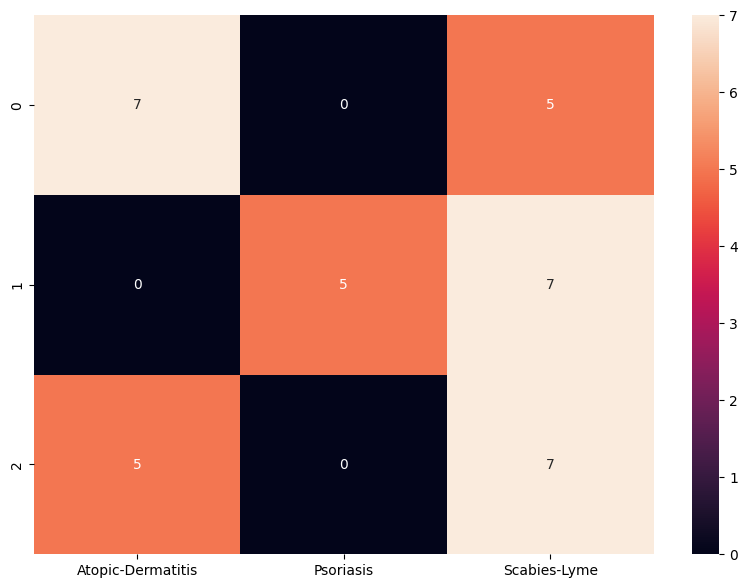

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)